In [2]:
!pip install monai

  Using cached monai-0.8.0-202111251823-py3-none-any.whl (709 kB)
  Using cached numpy-1.21.5-cp37-cp37m-win_amd64.whl (14.0 MB)


In [2]:
!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
  Attempting uninstall: torch
    Found existing installation: torch 1.10.1
    Uninstalling torch-1.10.1:
      Successfully uninstalled torch-1.10.1


In [2]:
!pip install -U pip
!pip install -U matplotlib
from monai.utils import (set_determinism, first)
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    EnsureChannelFirstd,
    RandAffined,
    RandRotated,
    RandGaussianNoised,
    ToTensord
)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, list_data_collate, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
from monai.data import DataLoader, Dataset, CacheDataset
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import numpy as np
from tqdm import tqdm
from PIL import Image as PILImageimport  

print_config()

MONAI version: 0.8.0
Numpy version: 1.21.5
Pytorch version: 1.10.1+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.0.0
Tensorboard version: 2.7.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.11.2+cu113
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, list_data_collate, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
from monai.data import DataLoader, Dataset, CacheDataset
import torch
import tempfile
import shutil
import os
import glob

print_config()

MONAI version: 0.8.0
Numpy version: 1.21.5
Pytorch version: 1.10.1+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 714d00dffe6653e21260160666c4c201ab66511b

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 9.0.0
Tensorboard version: 2.7.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.11.2+cu113
tqdm version: 4.62.3
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [6]:
root_dir="D:/isotropic_2/cropped_for_liyi"
data_dir= "C:/Users/Acer/Desktop/BME/pythonProject/Task09_Spleen"

In [12]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[1:36], data_dicts[36:45]

In [8]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
        EnsureTyped(keys=["image", "label"]),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

Code below shows difference between images through original transform and generat transform

image shape: torch.Size([226, 157, 113]), label shape: torch.Size([226, 157, 113])


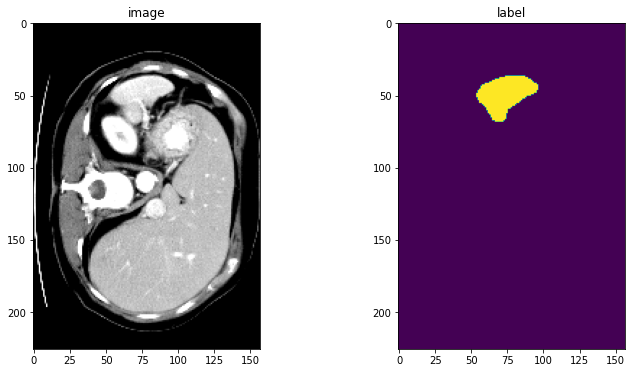

In [9]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

In [13]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
# train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|███████████████████████████████████████████████████████████████████| 5/5 [00:07<00:00,  1.43s/it]


In [11]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [18]:
max_epochs = 5
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    
    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()

            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"    
            )
            
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/5


OSError: [Errno 22] Invalid argument

In [ ]:
lungs = os.listdir(root_dir) #list of patient folders in root directory
tr=lungs[1:9] #names of folders for training set
vl=lungs[9:11] #names of folders for test set
path_train_volumes=[]
path_train_segmentation=[]
path_val_volumes=[]
path_val_segmentation=[]
    
for patient in tr:
    training_images = sorted(glob.glob(os.path.join(root_dir, patient, "CT", "*.nii.gz")));
    training_labels = sorted(glob.glob(os.path.join(root_dir, patient, "segmentations", "*.nii.gz")));
    path_train_volumes.append(training_images);
    path_train_segmentation.append(training_labels);
        
for patient in vl:
    vl_images = sorted(glob.glob(os.path.join(root_dir, patient, "CT","*.nii.gz")));
    vl_labels = sorted(glob.glob(os.path.join(root_dir, patient, "segmentations","*.nii.gz")));
    path_val_volumes.append(vl_images);
    path_val_segmentation.append(vl_labels);

#path_train_volumes = np.asarray(path_train_volumes)
#path_train_segmentation = np.asarray(path_train_segmentation)
#path_test_volumes = np.asarray(path_test_volumes)
#path_test_segmentation = np.asarray(path_test_segmentation)

#path_train_volumes = path_train_volumes.ravel()
#path_train_segmentation = path_train_segmentation.ravel()
#path_test_volumes = path_test_volumes.ravel()
#path_test_segmentation = path_test_segmentation.ravel()

train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)] 
val_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_val_volumes, path_val_segmentation)] 


original_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]), #load nifti files
            EnsureChannelFirstd(keys=["vol", "seg"]), #add a channel to our image and label
            EnsureTyped(keys=["vol", "seg"]), #convert transofrmed data into torch tensors for training 

        ]
    )

generat_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            EnsureChannelFirstd(keys=["vol", "seg"]),
            #RandAffined(keys=["vol", "seg"], prob=0.5, translate_range=10), 
            #RandRotated(keys=["vol", "seg"], prob=0.5, range_x=10.0),
            RandAffined(
             keys=["vol", "seg"],
             mode=("bilinear", "nearest"),
             prob=1.0, spatial_size=(96, 96, 96),
             rotate_range=(0, 0, np.pi/15),
             scale_range=(0.1, 0.1, 0.1)),
            RandGaussianNoised(keys="vol", prob=0.5),  
            EnsureTyped(keys=["vol", "seg"]),

        ]
    )
        
       
original_ds = Dataset(data=train_files, transform=original_transforms)
original_loader = DataLoader(original_ds, batch_size=1)
original_patient = first(original_loader)

generat_ds = Dataset(data=train_files, transform=generat_transforms)
generat_loader = DataLoader(generat_ds, batch_size=1)
generat_patient = first(generat_loader)

number_slice = 31
plt.figure("display", (12, 6))
plt.subplot(1, 2, 1)
plt.title(f"Original patient slice {number_slice}")
plt.imshow(original_patient["vol"][0, 0, :, :, number_slice], cmap="gray")
plt.subplot(1, 2, 2)
plt.title(f"Generated patient slice {number_slice}")
plt.imshow(generat_patient["vol"][0, 0, :, :, number_slice], cmap="gray")
plt.show()

In [71]:
set_determinism(seed=0)
    
lungs = os.listdir(root_dir) #list of patient folders in root directory
tr=lungs[1:5] #names of folders for training set
vl=lungs[5:6] #names of folders for test set
path_train_volumes=[]
path_train_segmentation=[]
path_val_volumes=[]
path_val_segmentation=[]
    
for patient in tr:
    training_images = sorted(glob.glob(os.path.join(root_dir, patient, "CT", "*.nii.gz")));
    training_labels = sorted(glob.glob(os.path.join(root_dir, patient, "segmentations", "*.nii.gz")));
    path_train_volumes.append(training_images);
    path_train_segmentation.append(training_labels);
        
for patient in vl:
    val_images = sorted(glob.glob(os.path.join(root_dir, patient, "CT","*.nii.gz")));
    val_labels = sorted(glob.glob(os.path.join(root_dir, patient, "segmentations","*.nii.gz")));
    path_val_volumes.append(val_images);
    path_val_segmentation.append(val_labels);

#path_train_volumes = np.asarray(path_train_volumes)
#path_train_segmentation = np.asarray(path_train_segmentation)
#path_test_volumes = np.asarray(path_test_volumes)
#path_test_segmentation = np.asarray(path_test_segmentation)

#path_train_volumes = path_train_volumes.ravel()
#path_train_segmentation = path_train_segmentation.ravel()
#path_test_volumes = path_test_volumes.ravel()
#path_test_segmentation = path_test_segmentation.ravel()

train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)] 
val_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_val_volumes, path_val_segmentation)] 


original_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]), #load nifti files
            EnsureChannelFirstd(keys=["vol", "seg"]), #add a channel to our image and label
            EnsureTyped(keys=["vol", "seg"]), #convert transofrmed data into torch tensors for training 

        ]
    )

generat_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            EnsureChannelFirstd(keys=["vol", "seg"]),
            #RandAffined(keys=["vol", "seg"], prob=0.5, translate_range=10), 
            #RandRotated(keys=["vol", "seg"], prob=0.5, range_x=10.0),
            RandAffined(
                keys=["vol", "seg"],
                mode=("bilinear", "nearest"),
                prob=1.0, spatial_size=(96, 96, 96),
                rotate_range=(0, 0, np.pi/15),
                scale_range=(0.1, 0.1, 0.1)),
                RandGaussianNoised(keys="vol", prob=0.5),  
                EnsureTyped(keys=["vol", "seg"]),

        ]
    )

#Source of transforms:'https://github.com/Project-MONAI/tutorials/blob/master/3d_segmentation/spleen_segmentation_3d.ipynb'
train_transforms = Compose(
    [
    LoadImaged(keys=["vol", "seg"]),
    transforms.Grayscale(num_output_channels=1),
    EnsureChannelFirstd(keys=["vol", "seg"]),
    Orientationd(keys=["vol", "seg"], axcodes="RAS"),
    RandCropByPosNegLabeld(
        keys=["vol", "seg"],
        label_key="seg",
        spatial_size=(96, 96, 96),
        pos=1,
        neg=1,
        num_samples=4,
        image_key="vol",
        image_threshold=0,
    ),
    RandAffined(
        keys=["vol", "seg"],
        mode=("bilinear", "nearest"),
        prob=1.0, spatial_size=(96, 96, 96),
        rotate_range=(0, 0, np.pi/15),
        scale_range=(0.1, 0.1, 0.1)),
        EnsureTyped(keys=["vol", "seg"]),
    ]
)

val_transforms = Compose(
    [
    LoadImaged(keys=["vol", "seg"]),
    transforms.Grayscale(num_output_channels=1),
    EnsureChannelFirstd(keys=["vol", "seg"]),
    Orientationd(keys=["vol", "seg"], axcodes="RAS"),
    EnsureTyped(keys=["vol", "seg"]),
    ]
)


train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0)
#train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
train_loader = DataLoader(train_ds, batch_size=1)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0)
#val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)   
val_loader = DataLoader(val_ds, batch_size=1) 

NameError: name 'transforms' is not defined

In [70]:
print(f'test dataloader size: {len(train_loader)}')
print(np.array(train_ds[1]).size())


test dataloader size: 4


TypeError: 'int' object is not callable

In [ ]:
Code below shows that prepare function works

Loading dataset:   0%|                                                                           | 0/8 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x000002DCD1E2BE58>
Traceback (most recent call last):
  File "C:\Users\Acer\anaconda3\envs\spleen segmentation\lib\site-packages\torch\utils\data\dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "C:\Users\Acer\anaconda3\envs\spleen segmentation\lib\site-packages\torch\utils\data\dataloader.py", line 1295, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Loading dataset: 100%|███████████████████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.71s/it]


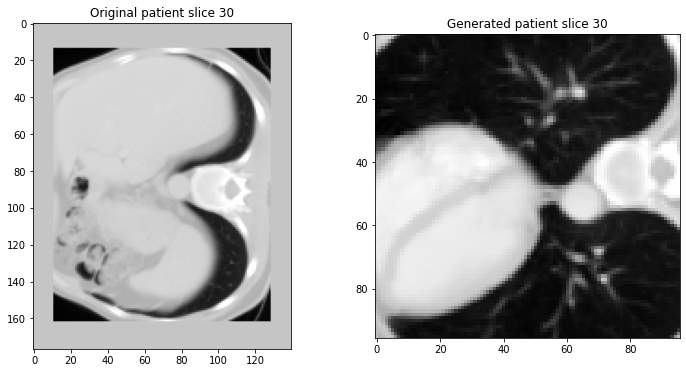

In [51]:
data_in = prepare(root_dir, cache=True)

number_slice = 30
plt.figure("display", (12, 6))
plt.subplot(1, 2, 1)
plt.title(f"Original patient slice {number_slice}")
plt.imshow(original_patient["vol"][0, 0, :, :, number_slice], cmap="gray")
plt.subplot(1, 2, 2)
plt.title(f"Generated patient slice {number_slice}")
plt.imshow(generat_patient["vol"][0, 0, :, :, number_slice], cmap="gray")
plt.show()

In [59]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
model = UNet(
    spatial_dims=3, #controls dimensions of convolution blocks (3 for 3D images)
    in_channels=5,  #in_channels = grayscale channel with two values(background:0, foreground:1)
    out_channels=2, #prediction for n class(es)
    channels=(16, 32, 64, 128, 256), #number of filters/kernels/feature maps
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [60]:
max_epochs = 2
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        epoch_loss = 0
        step = 0
        for batch_data in train_loader:
            step += 1
            inputs, labels = (
                batch_data["vol"].to(device),
                batch_data["seg"].to(device),
            )
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print(
                f"{step}/{len(train_ds) // train_loader.batch_size}, "
                f"train_loss: {loss.item():.4f}")
        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

        if (epoch + 1) % val_interval == 0:
            model.eval()
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs, val_labels = (
                        val_data["vol"].to(device),
                        val_data["seg"].to(device),
                    )
                    roi_size = (160, 160, 160)
                    sw_batch_size = 4
                    val_outputs = sliding_window_inference(
                        val_inputs, roi_size, sw_batch_size, model)
                    val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                    val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                    # compute metric for current iteration
                    dice_metric(y_pred=val_outputs, y=val_labels)

                # aggregate the final mean dice result
                metric = dice_metric.aggregate().item()
                # reset the status for next validation round
                dice_metric.reset()

                metric_values.append(metric)
                if metric > best_metric:
                    best_metric = metric
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(
                        root_dir, "best_metric_model.pth"))
                    print("saved new best metric model")
                print(
                    f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )

print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

----------
epoch 1/2


AssertionError: labels should have a channel with length equal to one.

In [ ]:
model = UNet(
    spatial_dims=3, #controls dimensions of convolution blocks (3 for 3D images)
    in_channels=1,  #in_channels = grayscale channel with two values(background:0, foreground:1)
    out_channels=2, #prediction for n class(es)
    channels=(16, 32, 64, 128, 256), #number of filters/kernels/feature maps
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)
#
loss_function = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-5, weight_decay=1e-5, amsgrad=True)

if __name__ == '__main__':
    train(model, data_in, loss_function, optimizer, 600, model_dir)